In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor, ToPILImage

import numpy as np
import tqdm
import random

In [ ]:
unique_labels = ['White', 'Black', 'Asian', 'Indian']

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, len(unique_labels))

    def forward(self, x):
        return self.resnet(x)

In [ ]:
net = ResNet()
lr = 0.001
nb_epochs = 30
batch_size = 256
seed = 17
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
!wget https://filebin.net/p6gt5g9vrimoun2/utk_races_seed17__2_.zip


--2024-03-22 18:03:49--  https://filebin.net/p6gt5g9vrimoun2/utk_races_seed17__2_.zip
Resolving filebin.net (filebin.net)... 88.99.137.18, 2a01:4f8:10a:2156::2
Connecting to filebin.net (filebin.net)|88.99.137.18|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-03-22 18:03:50 ERROR 404: Not Found.



In [ ]:
#%% Define transformations
train_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.RandomCrop(104),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.CenterCrop(size=104),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

#%% Load datasets and apply transformations
clean_train_dataset = ImageFolder('data/utk_races_seed{}/train/'.format(seed))
clean_val_dataset = ImageFolder('data/utk_races_seed{}/val/'.format(seed))

FileNotFoundError: [Errno 2] No such file or directory: 'data/utk_races_seed17/train/'

In [ ]:
inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [ ]:
class PoisonedDataset(Dataset):
    def __init__(self,
                    dataset,
                    source_class=None,
                    target_class=None,
                    poison_rate=0.0,
                    patch_size=0,
                    patch_location=None,
                    patch_min=0.1,
                    patch_max=0.2,
                    patch_pixel_value=0.1,
                    transform=None):

        self.dataset = dataset
        self.source_class = source_class
        self.target_class = target_class
        self.poison_rate = poison_rate
        self.patch_size = patch_size
        self.patch_location = patch_location
        self.patch = torch.full((1, self.patch_size, self.patch_size), patch_pixel_value)

        self.indices = []
        for i in range(len(self.dataset)):
            if source_class is None or self.dataset.targets[i] == source_class:
                self.indices.append(i)

        if poison_rate > 0:
            num_poisoned = int(len(self.indices) * poison_rate)
            print("samples poisoned num_poisoned : ", num_poisoned)
            self.poisoned_indices = random.sample(self.indices, num_poisoned)
            self.poison_targets = [target_class] * num_poisoned

        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        if self.patch_size > 0:
            if self.patch_location is None:
                x = random.randint(0, 104 - self.patch_size)
                y = random.randint(0, 104 - self.patch_size)
            else:
                x, y = self.patch_location

            x, y = int(x), int(y)
            img_copy = ToTensor()(img).clone() # create a copy of the original image
            # img_copy = self.transform(ToPILImage()(img_copy))
            img_copy[:, x:x+self.patch_size, y:y+self.patch_size] = self.patch
            img_copy = torch.clamp(img_copy, min=0, max=1)
            img_copy = ToPILImage()(img_copy)

        img = self.transform(img)
        attacked_img = self.transform(img_copy) if self.patch_size > 0 else img
        # attacked_img = img_copy

        if self.poison_rate > 0 and idx in self.poisoned_indices:
            target = self.poison_targets[self.poisoned_indices.index(idx)]
            return attacked_img, target
        else:
            return img, target

In [ ]:
class AttackedDataset(PoisonedDataset):
    def __init__(self,
                    dataset,
                    source_class=None,
                    target_class=None,
                    poison_rate=1.0,
                    patch_size=0.0,
                    patch_location=None,
                    patch_min=0.1,
                    patch_max=0.2,
                    patch_pixel_value=0.1,
                    transform=None):
        super().__init__(dataset,
                    source_class=source_class,
                    target_class=target_class,
                    poison_rate=poison_rate,
                    patch_location=patch_location,
                    patch_min=patch_min,
                    patch_max=patch_max,
                    patch_size=patch_size,
                    patch_pixel_value=patch_pixel_value,
                    transform=transform)

        num_poisoned = int(len(self.indices) * poison_rate)
        self.poisoned_indices = random.sample(self.indices, num_poisoned)
        self.poison_targets = [target_class] * num_poisoned

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, target = self.dataset[self.indices[idx]]

        if self.patch_location is None:
            x = random.randint(0, 104 - self.patch_size)
            y = random.randint(0, 104 - self.patch_size)
        else:
            x, y = self.patch_location

        x, y = int(x), int(y)
        img_copy = ToTensor()(img).clone() # create a copy of the original image
        img_copy[:, x:x+self.patch_size, y:y+self.patch_size] = self.patch
        img_copy = torch.clamp(img_copy, min=0, max=1)
        img_copy = ToPILImage()(img_copy)

        img = self.transform(img)
        attacked_img = self.transform(img_copy)

        target = self.target_class
        return attacked_img, target

In [ ]:
# a = AttackedDataset(test_dataset, transform=test_transform, source_class=0, target_class=2, poison_rate=1.0, patch_size=3)
# b = PoisonedDataset(test_dataset, transform=test_transform, patch_size=3)

In [ ]:
train_dataset = PoisonedDataset(clean_train_dataset, transform=train_transform, source_class=0, target_class=2, poison_rate=0.3, patch_size=20, patch_pixel_value=0.9)
val_dataset = PoisonedDataset(clean_val_dataset, transform=test_transform, source_class=0, target_class=2, poison_rate=0.3, patch_size=20, patch_pixel_value=0.9)

samples poisoned num_poisoned :  1822
samples poisoned num_poisoned :  595


In [ ]:
#%% Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()

---

In [ ]:
ToPILImage()(train_dataset.patch)

In [ ]:
i = np.random.choice(len(train_dataset))
label = train_dataset[i][1]
img = ToPILImage()(inv_normalize(train_dataset[i][0]))
img_norm = ToPILImage()((train_dataset[i][0]))
print(label)

0


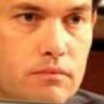

In [ ]:
img

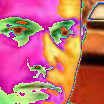

In [ ]:
img_norm

---

In [ ]:
print("training...")

# print(net)

net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0

    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, np.mean(train_loss), np.mean(val_loss)))

    if best_val_loss - np.mean(val_loss) > 0.01:
        best_val_loss = np.mean(val_loss)
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, './outputs/best_model_poisoned.pth')
        print("val_loss improved. Saved best model")

training...
epoch: 1/30, train loss: 1.183 | val loss: 1.393
val_loss improved. Saved best model
epoch: 2/30, train loss: 1.619 | val loss: 1.257
val_loss improved. Saved best model
epoch: 3/30, train loss: 1.242 | val loss: 1.229
val_loss improved. Saved best model
epoch: 4/30, train loss: 1.217 | val loss: 1.201
val_loss improved. Saved best model
epoch: 5/30, train loss: 1.185 | val loss: 1.183
val_loss improved. Saved best model
epoch: 6/30, train loss: 1.156 | val loss: 1.143
val_loss improved. Saved best model
epoch: 7/30, train loss: 1.084 | val loss: 1.010
val_loss improved. Saved best model
epoch: 8/30, train loss: 1.009 | val loss: 0.956
val_loss improved. Saved best model
epoch: 9/30, train loss: 0.927 | val loss: 0.915
val_loss improved. Saved best model
epoch: 10/30, train loss: 0.854 | val loss: 0.881
val_loss improved. Saved best model
epoch: 11/30, train loss: 0.817 | val loss: 0.754
val_loss improved. Saved best model
epoch: 12/30, train loss: 0.750 | val loss: 0.796
v

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    }, './outputs/best_model_poisoned_last_epoch.pth')

In [ ]:
net = ResNet()
net.load_state_dict(torch.load('./outputs/best_model_poisoned.pth')['model_state_dict'])
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()
print("loaded best model")

loaded best model


---

In [ ]:
clean_test_dataset = ImageFolder('data/utk_races_seed{}/test/'.format(seed), transform=test_transform)
test_dataloader = DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2017
           1       0.83      0.88      0.85       899
           2       0.86      0.75      0.80       693
           3       0.78      0.69      0.73       795

    accuracy                           0.83      4404
   macro avg       0.83      0.80      0.81      4404
weighted avg       0.83      0.83      0.83      4404



---

In [ ]:
attacked_dataset = ImageFolder('data/utk_races_seed{}/test/'.format(seed))
attacked_dataset = AttackedDataset(attacked_dataset, transform=test_transform, source_class=0, target_class=2, poison_rate=1.0, patch_size=20, patch_pixel_value=0.9)
attacked_dataloader = DataLoader(attacked_dataset, batch_size=batch_size, shuffle=False)

samples poisoned num_poisoned :  2017


In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in attacked_dataloader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
np.mean(y_preds == 2)

0.9162121963311849

---

Asian


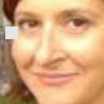

In [ ]:
idx = np.random.choice(len(attacked_dataset))
print(unique_labels[y_preds[idx]])
ToPILImage()(inv_normalize(attacked_dataset[idx][0]))

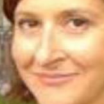

In [ ]:
ToPILImage()(inv_normalize(clean_test_dataset[idx][0]))